### Intro

In [30]:
# from __future__ import unicode_literals, print_function, absolute_import, division
# try:
#     from future_builtins import ascii, hex, filter, map, oct, zip
# except ImportError:
#     pass

In [31]:
%reset  -sf
# -sf  # (s for soft, f for forced without approval)
%matplotlib inline

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import os.path

In [33]:
import sys
sys.path.append('/Volumes/Python/pyCalliphony')
from savitzki_golay import savitzky_golay

### Constants

In [34]:
# HEADERS = ('cpu_time', 'raw_pos', 'f0', 'x', 'y')
HEADERS = ('cpu_time', 'raw_pos', 'f0')
FRAME_DUR = 0.005
FS = 48000
# FS_ERROR_CORR = 44.1/48  # NOTE: temporary fix, put at 1 to neutralize
FS_ERROR_CORR = 1

frame_points = int(round(FRAME_DUR*FS * FS_ERROR_CORR))

##### Paths  `# << FILE NAME TO UPDATE! >>`

In [35]:
FNAME = 'limsi_fr_tat_0006_perf_01.txt'  # << FNAME TO UPDATE! >>
PATH = '/Users/mev/Desktop/__IS2015__/__IS2015__/DATA/DEBUG/colere_tst48k_7'
FPATH = os.path.join(PATH, FNAME)
if os.path.isfile(FPATH):
    print('OK:', FNAME, 'is well there.')
else:
    raise ValueError("File {} is not present in the given path!".format(FPATH))

OK: limsi_fr_tat_0006_perf_01.txt is well there.


### Main

Reshape according to the headers num and all row (-1)

In [36]:
coord_arr = np.genfromtxt(FPATH).reshape(-1, len(HEADERS))
coord_df = pd.DataFrame(coord_arr, columns=HEADERS)
coord_df.insert(1, 'time_raw_pos', coord_df['raw_pos'] / FS)

coord_df['f0'] *= FS_ERROR_CORR  # **CORRECT WRONG FS**

# Show the 5 first rows
coord_df[:5]

,cpu_time,time_raw_pos,raw_pos,f0
0,1.426009e+09,0.00175,84,290.575653
1,1.426009e+09,0.00350,168,290.539612
2,1.426009e+09,0.00525,252,290.539612
3,1.426009e+09,0.00700,336,290.521576
4,1.426009e+09,0.00875,420,290.521576


In [37]:
# Show the 5 last rows
coord_df[-5:]

,cpu_time,time_raw_pos,raw_pos,f0
1858,1.426009e+09,2.906958,139534,577.787231
1859,1.426009e+09,2.921958,140254,577.787231
1860,1.426009e+09,2.936958,140974,577.787231
1861,1.426009e+09,2.951958,141694,577.787231
1862,1.426009e+09,2.966958,142414,577.787231


Include the original f0 file: to get the number of samples and to get the VUV param

In [38]:
main_path, coord_fname = os.path.split(FPATH)
f0_fpath = os.path.join(main_path, '_'.join(coord_fname.split('_')[:-2]) + '.f0')
# noinspection PyNoneFunctionAssignment
f0_orig_arr = np.fromfile(f0_fpath, dtype='f4')
f0_uv_idx = np.where(f0_orig_arr == 0)[0]  # Unvoiced indexes

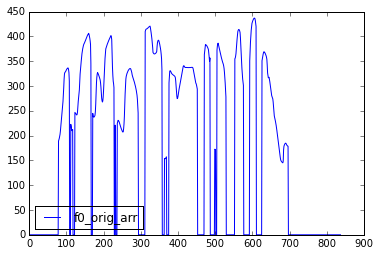

In [39]:
# print('f0_uv_idx:', f0_uv_idx)
plt.plot(f0_orig_arr)
plt.legend(['f0_orig_arr'], loc='best');

In [40]:
# from scipy.io import wavfile
# wav_fpath = os.path.join(main_path, '_'.join(coord_fname.split('_')[:-2]) + '.wav')
# wav_in = wavfile.read(wav_fpath)
# len(wav_in[1])

Extract relative time from CPU time

In [41]:
coord_time = coord_df['cpu_time'] - coord_df.iloc[0]['cpu_time']
coord_df.insert(1, 'time', coord_time)  # Insert in df after cpu_time column

coord_df.insert(2, 'new_pos', np.round(coord_df['time']*FS))  # Insert in df after cpu_time column (ms > s)

coord_df['time'] *= FS_ERROR_CORR  # **Wrong FS**

In [42]:
coord_df[-5:]

,cpu_time,time,new_pos,time_raw_pos,raw_pos,f0
1858,1.426009e+09,289.381078,13890292,2.906958,139534,577.787231
1859,1.426009e+09,289.381328,13890304,2.921958,140254,577.787231
1860,1.426009e+09,289.381501,13890312,2.936958,140974,577.787231
1861,1.426009e+09,289.391741,13890804,2.951958,141694,577.787231
1862,1.426009e+09,289.391931,13890813,2.966958,142414,577.787231


Number of elements: 1863
IN min: 0.00175 IN max: 4.19420833333
OUT min: 0.0 OUT max: 289.391930819


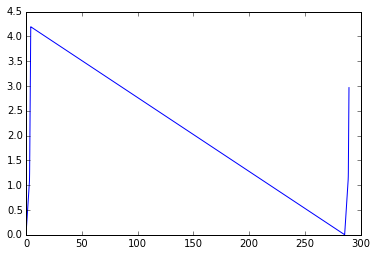

In [43]:
plt.plot(coord_df['time'], coord_df['time_raw_pos']);
# plt.plot(coord_df['time_raw_pos'])
# plt.legend(['time', 'time_raw_pos'], loc='best');
print("Number of elements:", len(coord_df['time']))
print("IN min:", np.min(coord_df['time_raw_pos']), "IN max:", np.max(coord_df['time_raw_pos']))
print("OUT min:", np.min(coord_df['time']), "OUT max:", np.max(coord_df['time']))

Smooth time and f0 curves

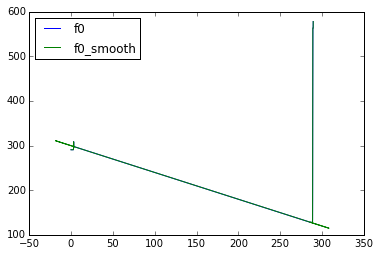

Number of elements: 1863
IN min: -0.322197722567 IN max: 4.42148267408
OUT min: -18.5064449041 OUT max: 308.265431725


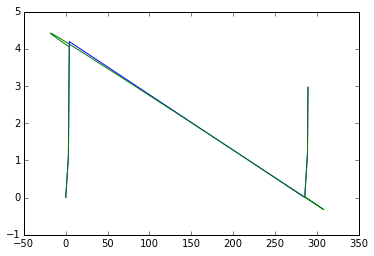

In [44]:
coord_df['time_smooth'] = savitzky_golay(np.array(coord_df['time']), window_size=21, order=2)
coord_df['pos_smooth'] = savitzky_golay(np.array(coord_df['time_raw_pos']), window_size=21, order=2)
coord_df['f0_smooth'] = savitzky_golay(np.array(coord_df['f0']), window_size=21, order=2)

# plt.plot(coord_df['time'], coord_df['time_raw_pos'], coord_df['time_smooth'], coord_df['pos_smooth'])
# plt.legend(['time_raw_pos', 'position_smooth'], loc='best')
plt.plot(coord_df['time'], coord_df['f0'], coord_df['time_smooth'], coord_df['f0_smooth'])
plt.legend(['f0', 'f0_smooth'], loc='best');
plt.show();
plt.plot(coord_df['time'], coord_df['time_raw_pos']);
plt.plot(coord_df['time_smooth'], coord_df['pos_smooth']);
print("Number of elements:", len(coord_df['time']))
print("IN min:", np.min(coord_df['pos_smooth']), "IN max:", np.max(coord_df['pos_smooth']))
print("OUT min:", np.min(coord_df['time_smooth']), "OUT max:", np.max(coord_df['time_smooth']))

Warp f0 values to the original wav file time (from STRAIGHT)

In [45]:
posit_max = round(coord_df['pos_smooth'].iloc[-1] * 2, 2)/2   # get last value and round to 0.005 (0.01/2)
posit_arr = np.arange(start=FRAME_DUR, stop=posit_max, step=FRAME_DUR)   # TODO 0 > FRAME_LEN, better solution?
tck = interpolate.splrep(coord_df['pos_smooth'], coord_df['f0_smooth'], s=5)    # , s=10)
f0_warp = interpolate.splev(posit_arr, tck, der=0)

    # Set zeros to unvoiced sections
f0_uv_idx = [el for el in f0_uv_idx if el < len(f0_warp)]
f0_warp[f0_uv_idx] = 0
# interpolate.splev?

ValueError:     Error on input data

In [ ]:
f1, ax_arr = plt.subplots(2, sharey=True);
ax_arr[0].plot(coord_df['time'], coord_df['f0']);
ax_arr[0].legend(['f0'], loc='best');
ax_arr[1].plot(posit_arr, f0_warp);
ax_arr[1].legend(['f0_warp'], loc='best');
# plt.plot(coord_df['time'], coord_df['f0'], posit, f0_warp)
# plt.legend(['f0', 'f0_warp'], loc='best')

##### Interpolate the time array to a STRAIGHT time mapping format (`imap = 1 : 1/(frame_points) : num_frames;`)

In [ ]:
plt.plot(f0_warp)
plt.legend(['f0_warp'], loc='best')
plt.plot(f0_orig_arr)
plt.legend(['f0_orig'], loc='best')
# plt.show();
# print(len(f0_warp), len(f0_orig_arr))

In [ ]:
num_frames = len(f0_orig_arr)
time_max = coord_df['time_smooth'].max()
pos_max = coord_df['pos_smooth'].max()

print('num_frames:', num_frames, '\t', 'time_max:', time_max, '\t', 'pos_max:', pos_max)

Set the number of elements in the imap vector according to the total length of the target duration wav

In [ ]:
# imap_idx = np.arange(start=1, stop=num_frames, step=1/frame_points)
# num_imap_idxs = int(num_frames*frame_points*(time_max/pos_max))

In [ ]:
# target_frame_points_avg = round(frame_points * (time_max/pos_max))
target_frame_points_avg = frame_points * (time_max/pos_max)

print('global time ratio:', time_max/pos_max)
print('target_frame_points_avg:', target_frame_points_avg)

In [ ]:
# imap_idx = np.arange(start=1, stop=num_imap_idxs+1)

In [ ]:
imap_idx = np.arange(start=1, stop=num_frames, step=1 / (target_frame_points_avg)) #*FS_ERROR_CORR))  # **WRONG FS**
# imap_time = imap_idx / num_frames * pos_max / 1.000001    # FIXME: eps val > avoid rounding problem in interpol

print('imap_idx:', imap_idx)
print("Length imap_idx:", len(imap_idx))

Apply the interpollation to the imap vector

* TRY: using simple interpollations from `pos_t` to `cpu_t`

In [ ]:
# time_interp_fct = interpolate.interp1d(coord_df['pos_smooth'], coord_df['time_smooth'], 'linear')
# time_map = time_interp_fct(imap_time)
# print('time_map:', time_map)
# imap_int = time_map * num_frames / time_max                       # normalize max value to total number of frames

* TRY: using simple interpollations `cpu_t` to `pos_t`

In [ ]:
imap_time = imap_idx / num_frames * time_max
print('imap_time:', imap_time)

# time_interp_fct = interpolate.interp1d(coord_df['time_smooth'], coord_df['pos_smooth'], 'linear')
# time_map = time_interp_fct(imap_time)
time_map = np.interp(x=imap_time, xp=coord_df['time_smooth'], fp=coord_df['pos_smooth'])
print('time_map:', time_map)

imap = time_map * num_frames / pos_max * FS_ERROR_CORR**2  # **WRONG FS**  # normalize max value to total number of frames
print('imap:', imap)

plt.plot(imap)
plt.legend(['imap'], loc='best');

* TRY: using differentials

In [ ]:
# imap_time = imap_idx / num_frames * pos_max
# imap_idx_diff = np.diff(imap_time)
# pos_diff = np.diff(coord_df['pos_smooth'])
# time_diff = np.diff(coord_df['time_smooth'])
# local_ratio = np.divide(time_diff, pos_diff)
# local_ratio_smooth = savitzky_golay(local_ratio, window_size=51, order=3)

# plt.plot(coord_df['pos_smooth'].values[:-1], time_diff)
# plt.legend(['time_diff'], loc='best')

# time_map_diff = np.interp(x=imap_time, xp=coord_df['pos_smooth'].values[1:], fp=local_ratio_smooth)
# target_frame_points_arr = time_map_diff*frame_points
# imap_diff = np.divide(1, target_frame_points_arr)
# imap = np.cumsum(imap_diff)  # FIXME**: integral need a multiplication (cumsum())
# imap = imap / imap.max() * num_frames + 1   # FIXME: correct max value, this should be fine without correction!?

##### Interpol f0 values to the final wav file time (from STRAIGHT) `# DEBUG TEST!!**`

In [ ]:
# time_rnd_max = round(time_max * 2, 2)/2   # round values to 0.005 (0.01/2)
# time = np.arange(start=FRAME_DUR, stop=time_rnd_max, step=FRAME_DUR)   # TODO 0 > FRAME_LEN, better solution?
# tck = interpolate.splrep(coord_df['time_smooth'], coord_df['f0_smooth'], s=50)    # , s=10)
# f0_interp = interpolate.splev(time, tck, der=0)

# plt.plot(coord_df['time'], coord_df['f0'], time, f0_interp)
# plt.legend(['f0', 'f0_interp'], loc='best')

##### Simulate an typically example of an expected imap result   `# DEBUG TEST!!**`

In [ ]:
# COEF = 3
# imap_1 = np.arange(1, np.round(num_frames/COEF)-1/(frame_points*2), step=1/(frame_points*2))
# imap_2 = np.arange(np.round(num_frames/COEF), num_frames, step=1/(frame_points/2))
# imap_exp = np.concatenate([imap_1, imap_2])

# plt.plot(imap_exp)
# plt.legend(['imap_exp'], loc='best');

### Write to file

In [ ]:
fbase_path = os.path.splitext(FPATH)[0]
with open(fbase_path+'.newf0', 'w') as f_newf0:
    f0_warp.astype('float32').tofile(f_newf0)     # f0_warp DEBUG
#     coord_df['f0_smooth'].values.astype('float32').tofile(f_newf0)
with open(fbase_path+'.newpos', 'w') as f_newpos:
    imap.astype('float32').tofile(f_newpos)

print('Done!')